In [38]:
%matplotlib inline
import tensorflow as tf
import keras as k
from keras import layers
from keras import Sequential
from tensorflow_datasets import load
from keras_preprocessing.image import ImageDataGenerator
from keras.models import clone_model

import numpy as np
import matplotlib.pyplot as plt

import cv2
import os

from PIL import Image
import sys

In [17]:
#ensure u have the right jupyter notebook version
print(sys.version_info)

sys.version_info(major=3, minor=11, micro=5, releaselevel='final', serial=0)


In [54]:
foo = 64
#data = None #set data to this value
#train_ds, test_ds = tf.keras.utils.split_dataset(data, left_size=0.8) #SPLIT DATASET --> COMBINE ALL DATA INTO ONE VARIABLE AND THIS WILL SPLIT IT
#class_num = data.shape()-2 #number of unique labels in data

"""
#In ISIC2018, task 3 is for full identification, task 1 is segmentation

#identification datasets
train_ds_X = load_folder_imgs("classi/ISIC2018_Task3_Training_Input") 
valid_ds_X = load_folder_imgs("classi/ISIC2018_Task3_Validation_Input") 
train_ds_y = load_folder_imgs("classi/ISIC2018_Task3_Training_GroundTruth")
valid_ds_y = load_folder_imgs("classi/ISIC2018_Task3_Validation_GroundTruth")

#segmentation datasets
train_gt_X = load_folder_imgs("seg/ISIC2018_Task1-2_Training_Input")
valid_gt_X = load_folder_imgs("seg/ISIC2018_Task1-2_Validation_Input")
train_gt_y = load_folder_imgs("seg/ISIC2018_Task1_Training_GroundTruth")
valid_gt_y = load_folder_imgs("seg/ISIC2018_Task1_Validation_GroundTruth")
"""
#include test data?
test_img = Image.open("seg\ISIC2018_Task1-2_Training_Input\ISIC2018_Task1-2_Training_Input\ISIC_0000001.jpg")

#https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task1-2_Training_Input.zip
U_Net = Sequential()
#change later
#data augmentation
"""

"""


U_Net.add(layers.Conv2D(filters=foo, kernel_size=3, padding="same", input_shape=(512,512,3)))
U_Net.add(layers.BatchNormalization())
#(x) --> using previous layer as input for next layer
U_Net.add(layers.Activation("relu"))

for filter in [64,128,256]:
    U_Net.add(layers.Conv2D(filters=filter, kernel_size=3, padding="same",activation="relu")) # (filters, kernel_size, padding, activation)
    U_Net.add(layers.BatchNormalization())

    U_Net.add(layers.Conv2D(filters=filter, kernel_size=3, padding="same",activation="relu"))
    U_Net.add(layers.BatchNormalization())

    U_Net.add(layers.MaxPooling2D(3, strides=2, padding="same")) # (pool_size, strides, padding)

#expanding u-net

for filter in [256, 128, 64]:
    U_Net.add(layers.Conv2DTranspose(filters=filter, kernel_size=3, padding="same",activation="relu"))
    U_Net.add(layers.BatchNormalization())

    U_Net.add(layers.Conv2DTranspose(filters=filter, kernel_size=3, padding="same",activation="relu"))
    U_Net.add(layers.BatchNormalization())
    U_Net.add(layers.UpSampling2D(2))
    

classification = Sequential([
    layers.Conv2D(7, kernel_size=3, activation="softmax", padding="same", input_shape=(512,512,64))
])
classification.summary()
#first input is # of classes

model = Sequential([
    #layers.Input(shape=(512, 512, 3)),
    layers.Resizing(height=512,width=512),
    layers.RandomContrast(factor=0.1),
    layers.RandomFlip(),
    layers.RandomRotation(factor=0.1),
    U_Net
    #classification
])
model.build(input_shape=(None,512,512,3))
model.summary()
model.save_weights('model.h5')
#model_final = tf.keras.Model(data, classification)

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_71 (Conv2D)          (None, 512, 512, 7)       4039      
                                                                 
Total params: 4039 (15.78 KB)
Trainable params: 4039 (15.78 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_8 (Resizing)       (None, 512, 512, 3)       0         
                                                                 
 random_contrast_8 (RandomC  (None, 512, 512, 3)       0         
 ontrast)                                                        
                                                                 
 random_flip_8 (RandomFlip)  (None, 512, 512, 3)       0      

In [29]:
"""
re = layers.Resizing(256,256)
resize_rescale = layers.Rescaling(1./255)(re)

pp = layers.RandomContrast(factor=0.1)
pp = layers.RandomFlip()(pp)
"""

#preprocessing = layers.RandomRotation(factor=0.2)(pp)

def conv_block(inputs, filters_n):
    n = layers.Conv2D(filters_n, 3, padding="same")(inputs)
    n = layers.BatchNormalization()(n)
    n = layers.Activation("relu")(n)
    
    n = layers.Conv2D(filters_n, 3, padding="same")(n)
    n = layers.BatchNormalization()(n)
    n = layers.Activation("relu")(n)
    
    return n

def encoder_block(inputs, filters_n):
    x = conv_block(inputs, filters_n)
    p = layers.MaxPool2D(pool_size=(2,2))(x)
    return x, p

def decoder_block(inputs, skip, filters_n):
    x = layers.Conv2DTranspose(filters_n, kernel_size=(2,2), strides=2, padding="same")(inputs)
    x = layers.Concatenate()([x, skip])
    x = conv_block(x, filters_n)
    return x


def U_Net(input_shape):
    inputs = layers.Input(shape=input_shape)
    
    #encode
    s1, out1 = encoder_block(inputs, 64)
    s2, out2 = encoder_block(out1, 128)
    s3, out3 = encoder_block(out2, 256)
    s4, out4 = encoder_block(out3, 512)
    
    #bottleneck
    bottleneck = conv_block(out4, 1024)
    
    #decode
    decode1 = decoder_block(bottleneck, s4, 512)
    decode2 = decoder_block(decode1, s3, 256)
    decode3 = decoder_block(decode2, s2, 128)
    decode4 = decoder_block(decode3, s1, 64)
    
    #condense 
    outputs = layers.Conv2D(1,1, padding="same", activation="sigmoid")(decode4)
    model = k.Model(inputs=inputs, outputs=outputs, name="unet")
    print(type(model))
    
    return model

model = U_Net((256,256,3))
model.summary()

<class 'keras.src.models.functional.Functional'>


Model: "unet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃ Param # ┃ Connected to         ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_23      │ (None, 256, 256,  │       0 │ -                    │
│ (InputLayer)        │ 3)                │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_274 (Conv2D) │ (None, 256, 256,  │   1,792 │ input_layer_23[0][0] │
│                     │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │     256 │ conv2d_274[0][0]     │
│ (BatchNormalizatio… │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ activation_254      │ (None, 256, 256,  │       0 │ batch_normalization… │
│ (Activation)        │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_275 (Conv2D) │ (None, 256, 256,  │  36,928 │ activation_254[0][0] │
│                     │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │     256 │ conv2d_275[0][0]     │
│ (BatchNormalizatio… │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ activation_255      │ (None, 256, 256,  │       0 │ batch_normalization… │
│ (Activation)        │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ max_pooling2d_60    │ (None, 128, 128,  │       0 │ activation_255[0][0] │
│ (MaxPooling2D)      │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_276 (Conv2D) │ (None, 128, 128,  │  73,856 │ max_pooling2d_60[0]… │
│                     │ 128)              │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │     512 │ conv2d_276[0][0]     │
│ (BatchNormalizatio… │ 128)              │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ activation_256      │ (None, 128, 128,  │       0 │ batch_normalization… │
│ (Activation)        │ 128)              │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_277 (Conv2D) │ (None, 128, 128,  │ 147,584 │ activation_256[0][0] │
│                     │ 128)              │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │     512 │ conv2d_277[0][0]     │
│ (BatchNormalizatio… │ 128)              │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ activation_257      │ (None, 128, 128,  │       0 │ batch_normalization… │
│ (Activation)        │ 128)              │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ max_pooling2d_61    │ (None, 64, 64,    │       0 │ activation_257[0][0] │
│ (MaxPooling2D)      │ 128)              │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_278 (Conv2D) │ (None, 64, 64,    │ 295,168 │ max_pooling2d_61[0]… │
│                     │ 256)              │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │   1,024 │ conv2d_278[0][0]   

 Total params: 31,055,297 (118.47 MB)

 Trainable params: 31,043,521 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [39]:
def load_folder_imgs(folder, numimgs, startind, img_shape):
    images = []
    folderfiles = os.listdir(folder)
    for i in range(numimgs):
        if len(folderfiles) > i+startind+1: 
            img = cv2.imread(os.path.join(folder,folderfiles[i+startind]))
            print(type(img))
            if img is not None:
                print("before resize: " + str(type(img)))
                
                images.append(np.array(cv2.resize(img, dsize=img_shape)))
                print(np.array(type(img)))
    """
    if None in images:
        print(images)
        print("none is in images")
    else:
        print("none is not in images")
    """
    return [images, i+startind]

#imagedatagenerator --> augments data, modify as wish
datagen = ImageDataGenerator(rescale=1./255,
                             rotation_range=0.1,
                             horizontal_flip=True,
                             vertical_flip=True,
                             )

In [40]:
#train U-net on ground truth
#train_gt_X = load_folder_imgs("seg\ISIC2018_Task1-2_Training_Input\ISIC2018_Task1-2_Training_Input")
#train_gt_y = load_folder_imgs("seg\ISIC2018_Task1_Training_GroundTruth\ISIC2018_Task1_Training_GroundTruth")
#train_gt_X

#print(train_gt_X)

#classification.trainable = False
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=["binary_accuracy"]) # we can actually use metrics without matplotlib!!!! woww!!! i think

callback_list = [tf.keras.callbacks.EarlyStopping(patience=2)] #can adjust to improve accuracy
batchsize=8
currentindx=0
currentindy=0
epochs = 4
#early stopping used to prevent overfitting


for i in range(epochs):
    currentindy=currentindx
    gtx = load_folder_imgs("seg\ISIC2018_Task1-2_Training_Input\ISIC2018_Task1-2_Training_Input", batchsize, currentindx, (256,256))
    gty = load_folder_imgs("seg\ISIC2018_Task1_Training_GroundTruth\ISIC2018_Task1_Training_GroundTruth", batchsize, currentindy, (256,256))
    gtx_aug, gty_aug = datagen.flow(gtx, gty, batch_size=batchsize, shuffle=True) #do data augmentation
    train_gt_X = gtx[0] 
    train_gt_y = gty[0]
    currentinx = gtx[1]
    currentiny = gty[1]
    
    #https://stackoverflow.com/questions/65474081/valueerror-data-cardinality-is-ambiguous-make-sure-all-arrays-contain-the-same
    train_gt_X = tf.stack(train_gt_X) 
    train_gt_y = tf.stack(train_gt_y)
    print("X len: "+ str(len(train_gt_X)) + ", y len: " + str(len(train_gt_y)))
    model.fit(x=train_gt_X, y=train_gt_y, batch_size=batchsize, callbacks=callback_list, verbose=0)
    print(f"Done training {i}!")



FileNotFoundError: [WinError 3] The system cannot find the path specified: 'seg\\ISIC2018_Task1-2_Training_Input\\ISIC2018_Task1-2_Training_Input'

In [ ]:
model.load_weights('model.h5')

In [43]:
#validation gt
#valid_gt_X = load_folder_imgs("seg/ISIC2018_Task1-2_Validation_Input")
#valid_gt_y = load_folder_imgs("seg/ISIC2018_Task1_Validation_GroundTruth")
model.evaluate(valid_gt, verbose=0, batch_size=32, steps=2)


NameError: name 'valid_gt' is not defined

In [ ]:
#train classification w/ U_net on full images
U_Net.trainable = False
classification.trainable = True

model.fit(x=train_ds_X, y=train_ds_y, epochs=10, batch_size=train_ds.length, callbacks=callback_list, verbose=2)

In [ ]:
#validation full

model.predict(valid_ds, verbose=0, batch_size=128, steps=2)


(256, 256, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
(128, 128, 3)
<class 'numpy.ndarray'>


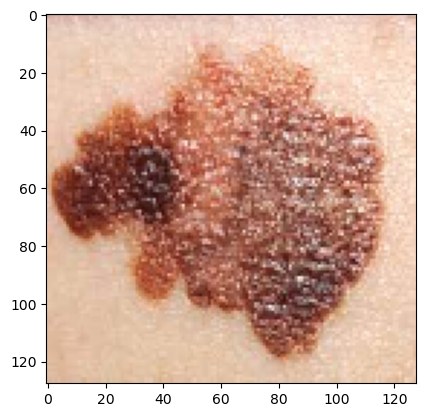

In [64]:
img = Image.open("melanoma.jpg")
img = img.resize((256,256))
plt.imshow(img)
img = np.array(img)


test = Sequential([
    layers.InputLayer(shape=(256,256,3)),
    layers.MaxPooling2D(pool_size=(2,2))
])

test.compile('adam', 'binary_cross_entropy')
print(img.shape)
img2 = np.expand_dims(img, 0)

res = test.predict(img2, steps=1)
res.shape
res2 = res[0,:,:,:]
print(res2.shape)
plt.imshow((res2).astype(np.uint8)) # *255 to negative??
#plt.imshow(img)
print(type(res2[0][0]))

In [ ]:
#compilation code here
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=["binary_accuracy"]) # we can actually use metrics without matplotlib!!!! woww!!! i think

callback_list = [tf.keras.callbacks.EarlyStopping(patience=2)] #can adjust to improve accuracy

#early stopping used to prevent overfitting

model.fit(train_ds, epochs=10, callbacks=callback_list)